# Introduction to General Linear Models

-----

In this notebook, we introduce general linear models, which provide a powerful approach for Bayesian model regression. One of the main benefits of using a general linear model is a simplified approach to computing a Bayesian model regression. However, the overall approach enables general models that are linear in that each coefficient is applied to a single variable or function of a single variable (which is similar to general linear modeling). 

-----

## Table of Contents

[Model and Test Data](#Model-and-Test-Data)

[General Linear Model](#General-Linear-Model)

- [Analyze Results](#Analyze-Results)
- [Visualize Results](#Visualize-Results)

[Non-Linear Modeling](#Non-Linear-Modeling)

- [Analyze Results](#Analyze-Results)
- [Visualize Results](#Visualize-Results)

-----

Before proceeding with the rest of this notebook, we first include the notebook setup code.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# These two lines suppress warnings that sometimes
# occur when making visualizations
import warnings
warnings.filterwarnings('ignore')

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default Seaborn plotting style
sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Model and Test Data

We reuse the model interface introduced in the Hierarchical Modeling notebook. However, in this notebook, we have one data set since we are fitting the entire data, as opposed to subsets of the data. Also, this model now introduces an optional quadratic term, which will enable more complex linear models to be compared.


-----

In [2]:
# Some common definitions
n_samples = 10000
n_burn = int(n_samples / 2)

# We define a simple function to fit.

np.random.seed(23)

# A non-linear equation
def theModel(x, params = None):

    # Default values
    beta = 0.5
    alpha = 0.25
    gamma = 0.2

    if params:
        alpha = params['Intercept']
        beta = params['x']
        gamma = params['np.power(x, 2)']

    return (alpha + beta * x  + gamma * x **2)

# Add random noise to model
def randomizeModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1
    
    x = np.linspace(xmin, xmax, num)   
    y = theModel(x) + sigma * np.random.randn(len(x))

    return(x, y)

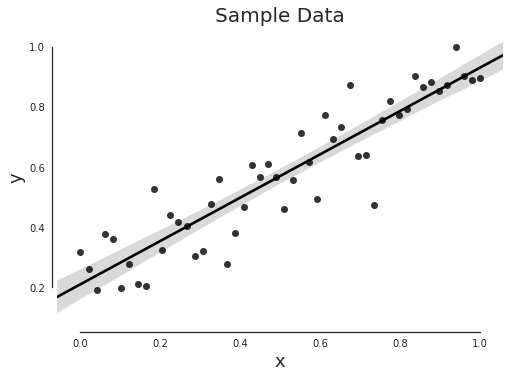

In [3]:
# Obtain sample data and plot data and model fit

x, y = randomizeModel(num = 50)

df = pd.DataFrame({'x': x, 'y': y})

ax = sns.regplot(data = df, x = 'x', y = 'y', \
                 fit_reg=True, color='black', label="Data")
ax.set(title='Sample Data')
sns.despine(offset=5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## General Linear Model

To fit a general linear model, we simply specify the functional form of our model. The technique makes reasonable assumptions for the prior distributions, and assumes a MAP starting point and NUTS sampler. As a result, the fitting procedure is greatly simplified. In this example, we fit a linear model (slope plus intercept) to the test data. As was the case with the _statsmodel_ library, we can use _R_ styled formulas.

-----

In [4]:
import pymc3 as pm

with pm.Model() as model_glm:
    pm.glm.glm('y ~ x', df)
    trace = pm.sample(n_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average ELBO = 6.2543: 100%|██████████| 200000/200000 [00:23<00:00, 8359.22it/s]
Finished [100%]: Average ELBO = 6.2398
100%|██████████| 10000/10000 [00:17<00:00, 580.74it/s]


-----

[[Back to TOC]](#Table-of-Contents)

### Analyze Results

As before, we can analyze the trace results (either with or without burn-in samples removed, in this example we have not removed the burn-in samples). Below we display the summary statistics for the intercept and slope model parameters (note that the slope is simply called `x` as defined in our model. We also visualize the traces, both the distribution of traces and their kernel density estimation.

-----

In [5]:
pm.summary(trace, ['Intercept', 'x'])


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.211            0.027            0.001            [0.154, 0.262]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.158          0.193          0.211          0.230          0.266


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.719            0.047            0.001            [0.629, 0.814]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.626          0.688          0.719          0.751          0.812



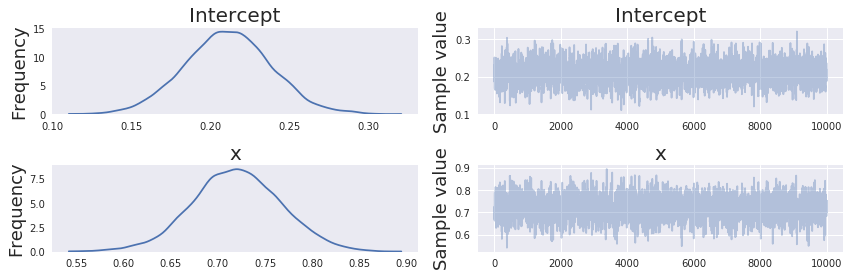

In [6]:
sns.set_style('darkgrid')

# We ignore the return values
_ = pm.traceplot(trace, ['Intercept', 'x'])

-----

[[Back to TOC]](#Table-of-Contents)

### Visualize Results

We can plot the data, the true regression, the final model regression, along with individual trace regressions in order to compare the performance of this technique. The trace regressions can be easily displayed by using the helper function `glm.plot_posterior_predictive`. One of the benefits of this approach is the demonstration of different traces sampling the likelihood space (and in some cases being wildly off), before settling down to the _expected_ values.

-----

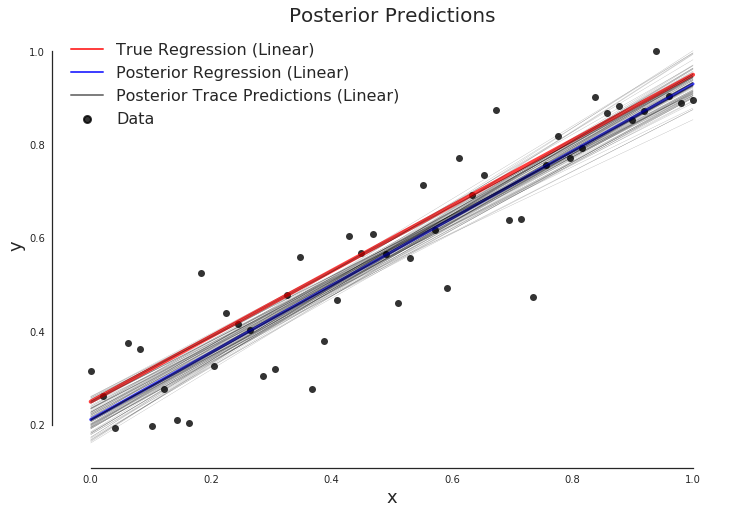

In [7]:
sns.set_style('white')

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# plot the data
sns.regplot(data = df, x = 'x', y = 'y', ax=ax,
            fit_reg=False, color='black', label="Data")

# Compute and plot the true relationship
x_sample = np.linspace(0.0, 1.0, 2)
y_sample = theModel(x_sample)
ax.plot(x_sample, y_sample, color='r', lw=4, alpha = 0.75, \
         label='True Regression (Linear)')

# Define the mean posterior parameters
params = {}
params['Intercept'] = np.mean(trace['Intercept'][-n_burn:]) 
params['x'] = np.mean(trace['x'][-n_burn:])
params['np.power(x, 2)'] = 0.0

# Compute and plot the mean posterior prediction
y_est = theModel(x_sample, params)
ax.plot(x_sample, y_est, color='b', lw=3, alpha = 0.75, \
         label='Posterior Regression (Linear)')

# Plot individual posterior predictions
pm.glm.plot_posterior_predictive(trace, samples=100, eval = x_sample, 
                                 alpha=0.5, 
                                 label='Posterior Trace Predictions (Linear)')

# Decorate plot
ax.set(title='Posterior Predictions', 
       xlabel='x', ylabel='y')

lgnd = ax.legend(loc='upper left')

for lg in lgnd.legendHandles:
    lg.set_linewidth(2.0)

# Clean-up
sns.despine(offset = 5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## Non-Linear Modeling

We can easily modify our model to capture non-linearities (despite the name of the approach, we only require that products of terms are not allowed, i.e., `x * cos(x)`). In this case, we fit a second order polynomial, with the caveat that the patsy library that interprets our functional forms does not understand the typical power operator. As a result, we must employ the (somewhat bulky) NumPy power operator. Otherwise, the modeling approach remains the same.

-----

In [8]:
# Patsy doesn't recognize Python power operator **, so we use np.power.

with pm.Model() as model_glm2:
    pm.glm.glm('y ~ x + np.power(x, 2)', df)
    trace = pm.sample(n_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -10.612: 100%|██████████| 200000/200000 [00:24<00:00, 8067.60it/s]
Finished [100%]: Average ELBO = -10.657
100%|██████████| 10000/10000 [00:42<00:00, 236.14it/s]


-----

[[Back to TOC]](#Table-of-Contents)

### Analyze Results

We can display the summary statistics for the traces as well as visualize the traces and their kernel density estimates. In doing so, we see one challenge of including the quadratic term is the lengthy name for the coefficient of the quadratic term, which is simply taken from the corresponding term in the formula supplied to the general linear model (`np.power(x, 2)`).

-----

In [9]:
pm.summary(trace, ['Intercept', 'x', 'np.power(x, 2)'])


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.239            0.040            0.001            [0.159, 0.317]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.160          0.212          0.239          0.265          0.318


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.550            0.185            0.006            [0.208, 0.914]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.194          0.426          0.550          0.675          0.904


np.power(x, 2):

  Mean             SD               MC Error         95% HPD interval
  ----------------

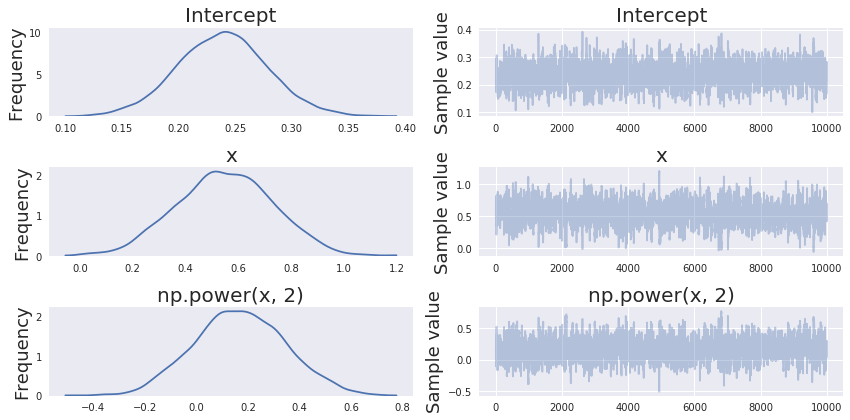

In [10]:
sns.set_style('darkgrid')

# We ignore the return values
_ = pm.traceplot(trace, ['Intercept', 'x', 'np.power(x, 2)'])

-----

[[Back to TOC]](#Table-of-Contents)

### Visualize Results

We can visualize the model fit and the procedure used to generate the fit as before. In this case, we supply the slope, intercept, and the quadratic term to the model function either from the original model or from the general linear modeling procedure. In this case, both the individual traces and the overall regression results capture the true relationship.

-----

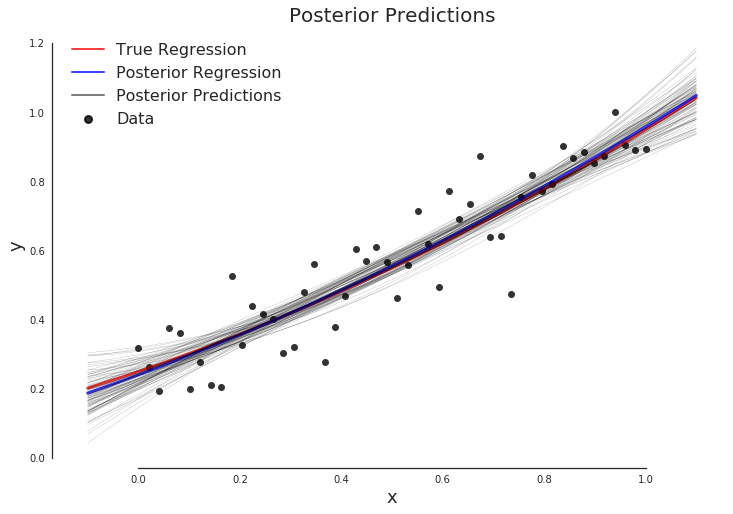

In [11]:
sns.set_style('white')

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# plot the data
sns.regplot(data = df, x = 'x', y = 'y', ax=ax,
            fit_reg=False, color='black', label="Data")

# Compute and plot the true relationship
x_sample = np.linspace(-0.1, 1.1, 100)
y_sample = theModel(x_sample)
ax.plot(x_sample, y_sample, color='r', lw=3, alpha = 0.75, 
        label='True Regression')

# Define the mean posterior parameters
params = {}
params['Intercept'] = np.mean(trace['Intercept'][-n_burn:]) 
params['x'] = np.mean(trace['x'][-n_burn:])
params['np.power(x, 2)'] = np.mean(trace['np.power(x, 2)'][-n_burn:])

# Compute and plot the mean posterior prediction
y_est = theModel(x_sample, params)
ax.plot(x_sample, y_est, color='b', lw=3, alpha = 0.75, 
        label='Posterior Regression')

# Plot individual posterior predictions
pm.glm.plot_posterior_predictive(trace, samples=100, 
                                 eval = x_sample, lm = theModel, 
                                 alpha=0.5, label='Posterior Predictions')

# Decorate plot
ax.set(title='Posterior Predictions', 
       xlabel='x', ylabel='y')

lgnd = ax.legend(loc='upper left')

for lg in lgnd.legendHandles:
    lg.set_linewidth(2.0)

# Clean-up
sns.despine(offset = 5, trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we introduced general liner models by using PyMC3. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Change the number of sample points both up and down, how does the `glm` fit change?
2. Replace the existing model by a higher order model (include third and possibly higher order terms). How well does the corresponding GLM fit the data?
3. One can use the Bayes factor to compare model fits (simply the ratio of the posteriors of the two models). Compute the Bayes factor for the linear and quadratic model fits to the original data.

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Wikipedia article on [general linear models][wglm]
2. Documentation for PyMC3 [general linear model][pymc3rr] and general linear models with [robust outlier detection][pymc3rro]
3. Chapter three on [general linear models][bmh3] from _Bayesian Method for Hackers_ by Cam Davidson Pilon
3. Chapter four on [general linear models][bmh4] from _Bayesian Method for Hackers_ by Cam Davidson Pilon
3. Chapter five on [general linear models][bmh5] from _Bayesian Method for Hackers_ by Cam Davidson Pilon
3. Chapter six on [general linear models][bmh6] from _Bayesian Method for Hackers_ by Cam Davidson Pilon

-----

[wglm]: https://en.wikipedia.org/wiki/Generalized_linear_model

[pymc3rr]: https://pymc-devs.github.io/pymc3/notebooks/GLM-robust.html
[pymc3rro]: https://pymc-devs.github.io/pymc3/notebooks/GLM-robust-with-outlier-detection.html

[bmh3]: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb

[bmh4]: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_PyMC3.ipynb

[bmh5]: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb

[bmh6]: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter6_Priorities/Ch6_Priors_PyMC3.ipynb

[bmps4]: http://nbviewer.jupyter.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%204.%20Bayesian%20regression.ipynb

[aibpymc3]: http://blog.applied.ai/bayesian-inference-with-pymc3-part-2/



**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode